# Embedded micro-bubble

We have simulated some very simple acoustic wave propagation, as well as an isolated micro-bubble. Now, we can combine both cases and embed micro-bubbles into our acoustic simulation.

In Stride, we do this by adding an extra term to the right-hand side of our acoustic wave equation,

$$
    \frac{1}{v_p^2} \frac{\partial^2 p}{\partial t^2} = \rho \nabla \cdot (\frac{1}{\rho} \nabla p) + \eta \frac{\partial}{\partial t} (-\nabla^2)^{y/2} p +\frac{\partial^2 V_f}{\partial t^2}
$$

where $V_f(t, \mathbf{x})$ is the instantaneous bubble volume fraction, which in 3D is approximately,

$$
    V_f \approx \sum_i \frac{4}{3} \pi R_i^3 n \delta(\mathbf{x} - \mathbf{x}_i)
$$

where $R_i(t)$ is the instantaneous radius of each micro-bubble, $\mathbf{x}_i$ is the spatial location of each bubble, $n$ is the micro-bubble concentration, and $\delta()$ is the Dirac delta function.

## Baseline acoustic simulation

We will start by reproducing the simple acoustic modelling from the previous notebook in order to have a baseline to compare our bubble simulations.

In [1]:
from stride import *
%matplotlib notebook

import numpy as np

Let's create a spatiotemporal grid,

In [2]:
# Create the grid
space = Space(shape=(100, 100, 100),
              spacing=0.05e-3,
              extra=(30, 30, 30),
              absorbing=(20, 20, 20))

time = Time(start=0, step=0.005e-6, num=1500)

and a `problem`.

In [3]:
problem = Problem(name='embedded_bubble',
                  space=space, time=time)

As before, we assign constant speed of sound and density to our simulation region.

In [4]:
vp = ScalarField(name='vp', grid=problem.grid)
vp.fill(1540.)

rho = ScalarField(name='rho', grid=problem.grid)
rho.fill(997)

problem.medium.add(vp)
problem.medium.add(rho)

We will use default transducers,

In [5]:
problem.transducers.default()

and the same elliptical geometry with 120 elements.

In [6]:
num_locations = 120
problem.geometry.default('elliptical', num_locations, radius=np.array(space.size)/2)

We define a shot, selecting the first location to act as a source and all of them to act as receivers.

In [7]:
source = problem.geometry.locations[0]
receivers = problem.geometry.locations

shot = Shot(source.id,
            sources=[source], receivers=receivers,
            geometry=problem.geometry, problem=problem)

problem.acquisitions.add(shot)

We excite the source with a tone burst centred at 2 MHz.

In [8]:
from stride.utils import wavelets

f_centre = 2.00e6
n_cycles = 6

shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles,
                                               time.num, time.step) * 5e7

We instantiate our PDE,

In [9]:
pde = IsoAcousticDevito(space=space, time=time, dtype=np.float64)

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp


and run it as before.

In [10]:
sub_problem = problem.sub_problem(shot.id)
shot_wavelets = sub_problem.shot.wavelets

traces_0 = await pde(shot_wavelets, vp, rho=rho, problem=sub_problem, 
                     diff_source=True,
                     boundary_type='complex_frequency_shift_PML_2',
                     save_wavefield=True, save_undersampling=20)

wavefield_0 = pde.wavefield.data[:, :, pde.wavefield.shape[-1]//2].copy()

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 1.600-2.400 MHz
(ShotID 0) Spatial grid spacing (0.050 mm | 12.833 PPW) is below dispersion limit (0.128 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.005 μs | 15%) is below OT2 limit (0.012 μs)
(ShotID 0) Selected undersampling level 20
(ShotID 0) Selected time stepping scheme OT2
Operator `acoustic_iso_state` instance configuration:
	 * subs={h_x: 5e-05, h_y: 5e-05, h_z: 5e-05}
	 * opt=advanced
	 * platform=None
Operator `acoustic_iso_state` generated in 18.22 s
  * lowering.Clusters: 11.51 s (63.2 %)
     * specializing.Clusters: 6.70 s (36.8 %)
        * fuse: 4.36 s (24.0 %)
  * lowering.Expressions: 4.26 s (23.4 %)
Flops reduction after symbolic optimization: [5668 --> 1306]
Operator `acoustic_iso_state` fetched `/tmp/devito-jitcache-uid1000/09185d1cbee216e49094c2430518fc1f3f7a43d1.c` in 0.67 s from jit-cache
(ShotID 0) Using inhomogeneous density
(ShotID 0) Running state equati

## Single bubble

At this point, we can start introducing our micro-bubbles, starting by adding a single micro-bubble to our simulation.

To do that, we first define the bubble properties.

In [11]:
sigma = 0.073       # [N/m]     the surface tension of the surrounding liquid
mu = 0.002          # [Pa s]    the viscosity of the surrounding liquid
p_0 = 101325        # [Pa]      the ambient pressure
kappa = 1.07        # [-]       the polytropic gas exponent
kappa_s = 5E-9      # [N]       the surface dilatational viscosity from the monolayer
chi = 0.4           # [N/m]     the elastic compression modulus of the monolayer
r_buckle = 2.08e-6  # [m]       the buckling radius of the bubble
r_break = 2.28e-6   # [m]       the breaking radius of the bubble

Then, wen define the initial bubble conditions, the bubble's initial radius, by creating a `SparseField` object.

In [12]:
r_0 = SparseField(name='r_0', num=1, grid=problem.grid)
r_0.data[0] = 2.20e-06

We also create a `ParticleField` object to define where in the simulation region the bubble will be located: in this case at its centre.

In [13]:
x_0 = ParticleField(name='x_0', num=1, grid=problem.grid)
x_0.data[0, :] = np.array(space.size) / 2

Importantly, bubbles in Stride are not constrained to be defined on grid-points. They can be defined anywhere and their response will be correctly interpolated.

To couple the Marmottant ODE with the acoustic PDE, we will add the Marmottant class as a sub-operator to the acoustic wave equation.

In [14]:
pde.add_sub_op(MarmottantDevito)

Default Devito configuration:
	 * autotuning=['aggressive', 'runtime']
	 * develop-mode=False
	 * mpi=False
	 * log-level=DEBUG
	 * language=openmp


Now, we can run our acoustic PDE as before, taking care to also pass in any arguments that are needed to define the bubble properties.

In [15]:
traces_1 = await pde(shot_wavelets, vp, rho=rho,
                     r_0=r_0, x_0=x_0,
                     sigma=sigma, mu=mu,
                     p_0=p_0, kappa=kappa, kappa_s=kappa_s,
                     chi=chi, r_buckle=r_buckle, r_break=r_break,
                     problem=sub_problem, diff_source=True,
                     save_wavefield=True, save_undersampling=20,
                     boundary_type='complex_frequency_shift_PML_2',
                     num_inner=100)

wavefield_1 = pde.wavefield.data[:, :, pde.wavefield.shape[-1]//2].copy()

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 1.600-2.400 MHz
(ShotID 0) Spatial grid spacing (0.050 mm | 12.833 PPW) is below dispersion limit (0.128 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.005 μs | 15%) is below OT2 limit (0.012 μs)
(ShotID 0) Selected undersampling level 20
(ShotID 0) Selected time stepping scheme OT2
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Operator `acoustic_iso_state` 

It is important to note the last argument in the PDE call, `num_inner=100`. The PDE and the ODE have different stability regions, so they also have different requirements in terms of time discretisation. We solve this by running Marmottant on an inner loop for every step of the acoustic wave equation. In this case, we chose this inner loop to consist of 100 steps.

If we plot the traces that result from the simulation, we will not be able to see many differences with respect to the case with no bubble.

<IPython.core.display.Javascript object>


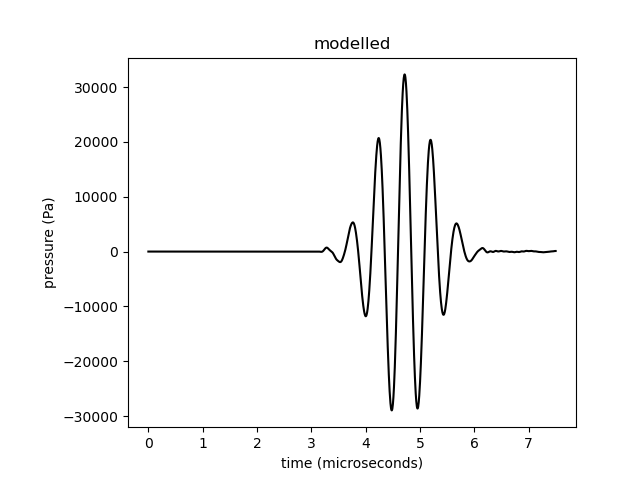

In [16]:
import matplotlib.pyplot as plt

traces_1.plot_one(60, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('pressure (Pa)')
plt.subplots_adjust(left=0.2)
plt.show()

However, if we subtract the result of the baseline simulation, we will be able to see the non-linear signal generated by the embedded micro-bubble. 

<IPython.core.display.Javascript object>


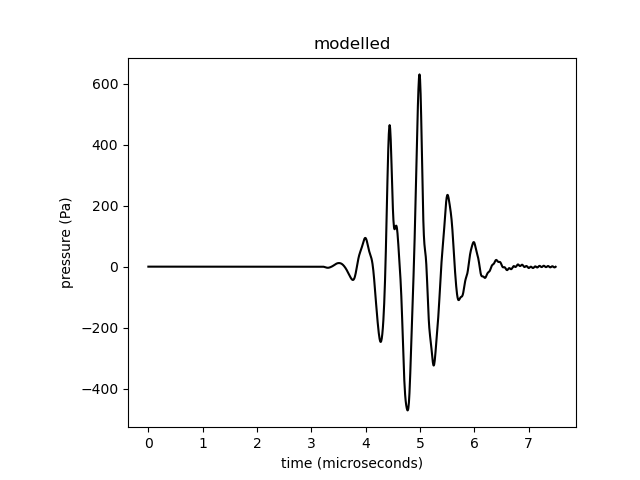

In [17]:
traces = traces_1 - traces_0
traces.plot_one(60, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('pressure (Pa)')
plt.subplots_adjust(left=0.2)
plt.show()

We can also look at the magnitude spectrum of this signal and compare it with the signal used to excite the source. 

<IPython.core.display.Javascript object>


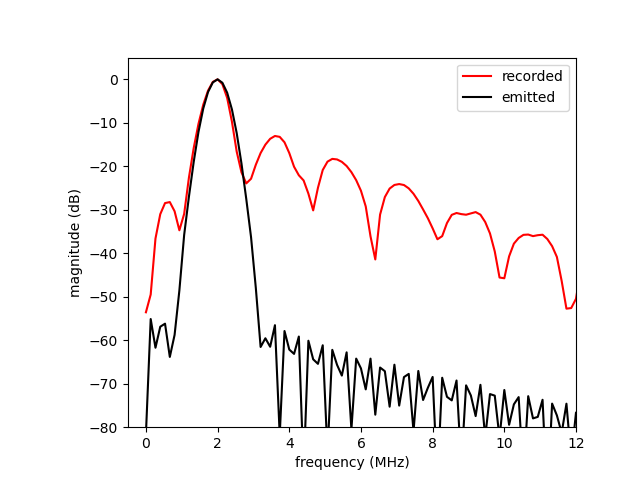

In [18]:
from stride.utils import fft

freq, wavelet_fft = fft.magnitude_spectrum(shot.wavelets.data[0], time.step)
freq, traces_fft = fft.magnitude_spectrum(traces.data[0], time.step)

plt.figure()

plt.plot(freq*1e-6, traces_fft, c='r')
plt.plot(freq*1e-6, wavelet_fft, c='k')

plt.xlim([-0.5, 12])
plt.ylim([-80, 5])

plt.legend(['recorded', 'emitted'])

plt.xlabel('frequency (MHz)')
plt.ylabel('magnitude (dB)')
plt.subplots_adjust(left=0.2)
plt.show()

plt.show()

We can clearly see the excitation of high-order harmonics due to the non-linear behaviour of the bubble.

Plotting the wavefield using two scales for the incident and scattered field will allow us to visualise this more easily.

<IPython.core.display.Javascript object>


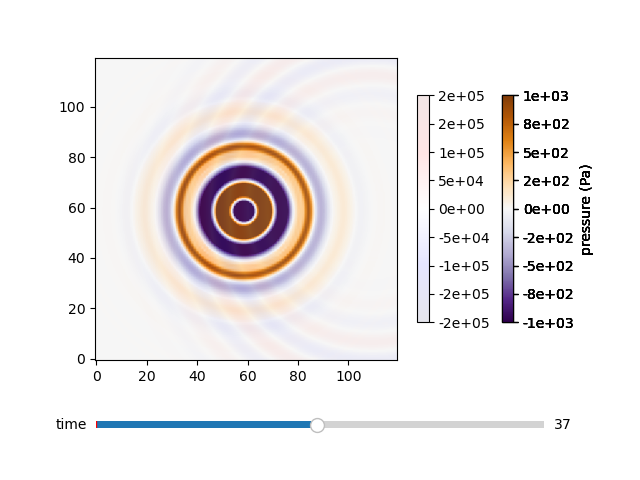

In [19]:
from utils import plot_wavefields

plot_wavefields([wavefield_1-wavefield_0, wavefield_0],
                [dict(vmin=-1e3, vmax=1e3, cmap='PuOr_r'),
                 dict(vmin=-200e3, vmax=200e3, cmap='seismic', alpha=0.1)])

## Multiple bubbles

So far, we have been looking at single bubbles. Let's add ten bubbles to our simulation to see what would be the effect.

We can do this by defining the initial radius and the location of our bubbles using the parameter `num=10`.

In [20]:
r_0 = SparseField(name='r_0', num=10, grid=problem.grid)
r_0.data[:] = 2.2000e-06

x_0 = ParticleField(name='x_0', num=10, grid=problem.grid)

np.random.seed(2021)
for index in range(x_0.num):
    x_0.data[index, :] = np.array(space.size) / 2
    x_0.data[index, :] += (np.random.rand(3)*2 - 1)*1e-3

We can then run our PDE as before, passing in the new `r_0` and `x_0`.

In [21]:
traces_2 = await pde(shot_wavelets, vp, rho=rho,
                         r_0=r_0, x_0=x_0,
                         sigma=sigma, mu=mu,
                         p_0=p_0, kappa=kappa, kappa_s=kappa_s,
                         chi=chi, r_buckle=r_buckle, r_break=r_break,
                         problem=sub_problem, diff_source=True,
                         save_wavefield=True, save_undersampling=20,
                         boundary_type='complex_frequency_shift_PML_2',
                         num_inner=100)

wavefield_2 = pde.wavefield.data[:, :, pde.wavefield.shape[-1]//2].copy()

(ShotID 0) Preparing to run state for shot
(ShotID 0) Estimated bandwidth for the propagated wavelet 1.600-2.400 MHz
(ShotID 0) Spatial grid spacing (0.050 mm | 12.833 PPW) is below dispersion limit (0.128 mm | 5.000 PPW)
(ShotID 0) Time grid spacing (0.005 μs | 15%) is below OT2 limit (0.012 μs)
(ShotID 0) Selected undersampling level 20
(ShotID 0) Selected time stepping scheme OT2
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Ensure that the provided interpolation coefficient and grid point values are computed on the final grid that will be used for other computations.
Operator `acoustic_iso_state` 

Subtracting the baseline simulation, we will now be able to see the signal coming from alll bubbles.

<IPython.core.display.Javascript object>


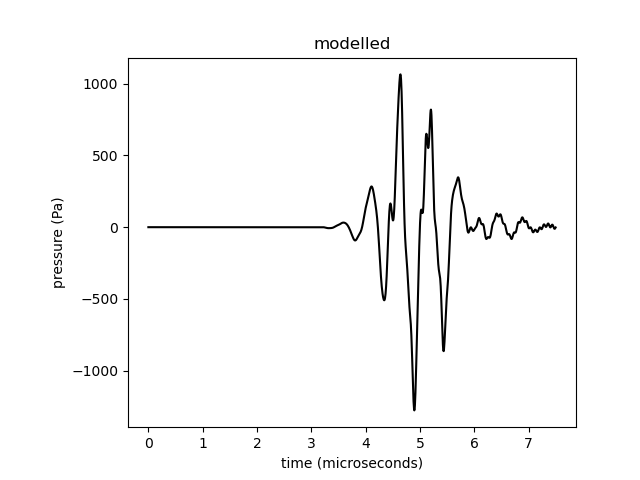

In [22]:
traces = traces_2 - traces_0
traces.plot_one(60, plot=False)
plt.xlabel('time (microseconds)')
plt.ylabel('pressure (Pa)')
plt.subplots_adjust(left=0.2)
plt.show()

And the wavefield will show the complex field scattered by the 10 bubbles.

<IPython.core.display.Javascript object>


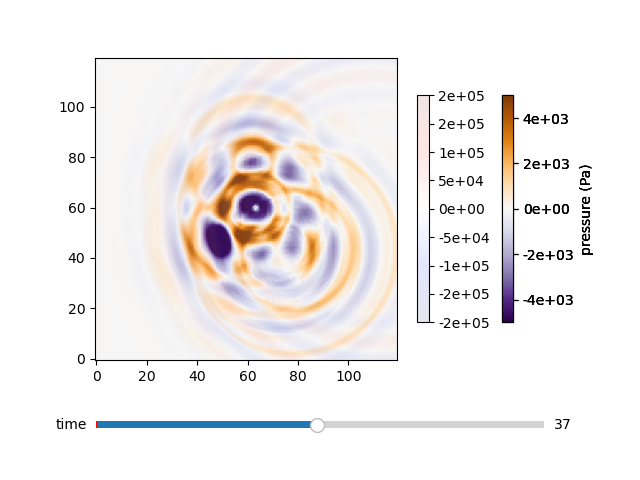

In [23]:
plot_wavefields([wavefield_2-wavefield_0, wavefield_0],
                [dict(vmin=-5e3, vmax=5e3, cmap='PuOr_r'),
                 dict(vmin=-200e3, vmax=200e3, cmap='seismic', alpha=0.1)])